Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

Библиотеки: [Python, Tensorflow]

In [1]:
import wget
import shutil
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# if 1:
#     !pip install scikit-video==1.1.11
import skvideo.io

Загрузка датасета

In [3]:
urls = ['http://www.nada.kth.se/cvap/actions/walking.zip', 
        'http://www.nada.kth.se/cvap/actions/jogging.zip',
       'http://www.nada.kth.se/cvap/actions/running.zip',
       'http://www.nada.kth.se/cvap/actions/boxing.zip',
       'http://www.nada.kth.se/cvap/actions/handwaving.zip',
       'http://www.nada.kth.se/cvap/actions/handclapping.zip']


In [4]:
%%time
for url in urls:
    output = os.path.join(url.split('/')[-1])
    filename = wget.download(url, output)
    # if os.path.exists(output):
    #    shutil.move(filename, output)

-1 / unknownWall time: 18min 50s


In [5]:
import zipfile, fnmatch

rootPath = r"D:\kth"
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        print(os.path.join(root, filename))
        zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))

D:\kth\boxing.zip
D:\kth\handclapping.zip
D:\kth\handwaving.zip
D:\kth\jogging.zip
D:\kth\running.zip
D:\kth\walking.zip


Подготовка датасета

In [3]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [4]:
print('Dataset samples (total):', len(dataset))

Dataset samples (total): 599


In [5]:
TRAIN_LEN = 400
random.shuffle(dataset)
train_ds = dataset[:TRAIN_LEN]
test_ds = dataset[TRAIN_LEN:]

print('Dataset samples (train):', len(train_ds))
print('Dataset samples (test):', len(test_ds))

Dataset samples (train): 400
Dataset samples (test): 199


In [6]:
import skvideo
skvideo.setFFmpegPath(r'C:\ffmpeg\bin')
import skvideo.io

videodata shape: (396, 120, 160, 3)


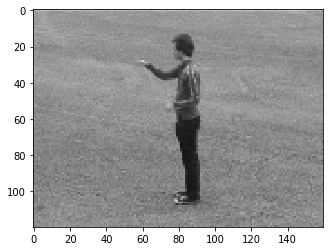

In [7]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

motion shape: (395, 120, 160, 1)


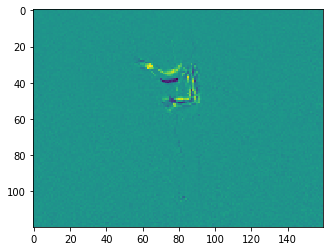

In [8]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

Создание модели

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (2, 3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Reshape((1, 64)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation=None),
])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            multiple                  4032      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv3d_5 (Conv3D)            multiple                  256064    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv3d_6 (Conv3D)            multiple                  110656    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 multiple                  0         
_________________________________________________________________
conv3d_7 (Conv3D)            multiple                 

In [14]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 1491, 120, 160, 1)
Output shape: (1, 6)


In [15]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [16]:
%%time
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(train_ds):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(train_ds)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/5][0/400] Loss = 1.7916569709777832
[0/5][10/400] Loss = 1.802699327468872
[0/5][20/400] Loss = 1.7934250831604004
[0/5][30/400] Loss = 1.7843422889709473
[0/5][40/400] Loss = 1.7668492794036865
[0/5][50/400] Loss = 1.7898906469345093
[0/5][60/400] Loss = 1.79166841506958
[0/5][70/400] Loss = 1.80538809299469
[0/5][80/400] Loss = 1.7859807014465332
[0/5][90/400] Loss = 1.8049726486206055
[0/5][100/400] Loss = 1.801020860671997
[0/5][110/400] Loss = 1.8521796464920044
[0/5][120/400] Loss = 2.2620182037353516
[0/5][130/400] Loss = 1.187707781791687
[0/5][140/400] Loss = 1.8666408061981201
[0/5][150/400] Loss = 2.0026886463165283
[0/5][160/400] Loss = 1.6287349462509155
[0/5][170/400] Loss = 1.7736271619796753
[0/5][180/400] Loss = 1.1682031154632568
[0/5][190/400] Loss = 1.3349835872650146
[0/5][200/400] Loss = 2.1408519744873047
[0/5][210/400] Loss = 1.8238935470581055
[0/5][220/400] Loss = 1.0123929977416992
[0/5][230/400] Loss = 0.7804648280143738
[0/5][240/400] Loss = 1.0359187126

In [17]:
model.save_weights('hw07_video_classification_model_weights')

In [22]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9196), started 0:05:02 ago. (Use '!kill 9196' to kill it.)

Tensorboard все также не работает

Тестирование модели

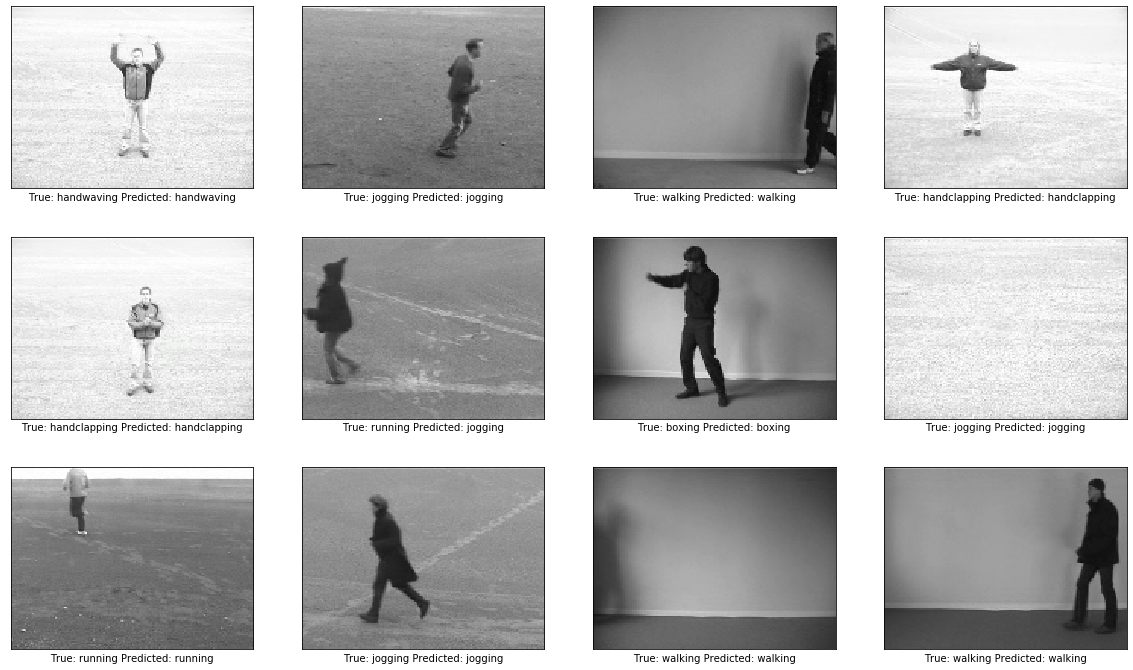

In [35]:
fig = plt.figure(figsize=(20, 12))
for j in range(12):
    fpath, cls_true = random.choice(test_ds)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    ax = fig.add_subplot(3, 4, j+1)
    ax.imshow(videodata[30, ...])
    my_string = 'True: ' + classes[cls_true] + ' Predicted: ' + classes[cls_pred]
    ax.set_xlabel(my_string)
    plt.xticks([]), plt.yticks([])
plt.show()

В целом модель хорошо работает на тестовых данных, частая ошибка случается только между jogging (бег трусцой) и  running (бег), но это вполне похожие понятия.